**In this code, we will use ImageDataGenerator to generate new images from train data images (using image augmentation technique). This technique helps in increasing the training data, which will help in building more accurate models.**

**Loading the required packages**

In [0]:
import tensorflow as tf
print(tf.__version__)

In [0]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [0]:

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

**Loading the a sample image to understand how image augmentation works.**

In [0]:
from google.colab import files
files.upload()

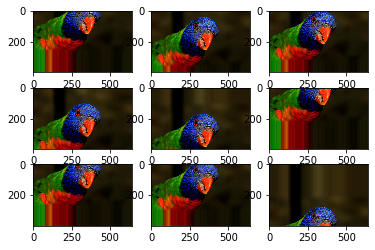

In [0]:
#Understanding how fit_generator works

# example of vertical shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('bird.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.5)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

**Above example shows that how multiple images can be generated from a single image.**

**Let's load the handwritten digit data, on which we will apply the image augmentation technique.**

In [0]:
mnist = tf.keras.datasets.mnist
(x_train,y_train), (x_test,y_test) = mnist.load_data()

x_train = np.array(x_train)
print(x_train.shape)

x_test = np.array(x_test)
print(x_test.shape)

y_train = np.array(y_train)
print(y_train.shape)

y_test = np.array(y_test)
print(y_test.shape)


(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [0]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
#example:
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


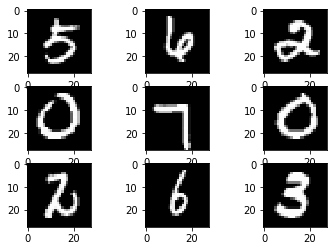

In [0]:
#Understanding how fit_generator works

# define data preparation
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit parameters from data
datagen.fit(x_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 9):
		pyplot.subplot(330 + 1 + i)
		pyplot.imshow(X_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
	# show the plot
	pyplot.show()
	break

**Creating CNN layers**

In [0]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

**Defining ImageDataGenerator**

In [0]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

**Splitting data into train & validation data**

In [0]:
x_val = x_train[0:12000,:,:,:]
y_val = y_train[0:12000,:]

x_train1 = x_train[12000:,:,:,:]
y_train1 = y_train[12000:,:]

print(x_train1.shape)
print(x_val.shape)

print(y_train1.shape)
print(y_val.shape)


(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000, 10)
(12000, 10)


**Fitting the model on images generated from ImageDataGenerator.**

In [0]:
#When using LearningRateScheduler

model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

#RMSprop adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. 
#Adam is an update to the RMSProp optimizer which is like RMSprop with momentum

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

#The steps_per_epoch will be the total number of samples in your training set (before augmentation) divided by the batch size
#60000/32 = 1875

hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                           steps_per_epoch=1875,
                           epochs=20, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val, y_val), #For speed
                           callbacks=[annealer])

In [0]:
#Without using LearningRateScheduler


from keras.callbacks import EarlyStopping
# Instantiate an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)


# Import model checkpoint from keras callbacks
from keras.callbacks import ModelCheckpoint

# Instantiate a model checkpoint callback
model_save = ModelCheckpoint('best_model.hdf5',
save_best_only=True)


model.compile(loss='categorical_crossentropy', optimizer = Adam(), metrics=["accuracy"])
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                           steps_per_epoch=1875,
                           epochs=20,
                           verbose=2,  validation_data=(x_val, y_val),
                            callbacks = [model_save,early_stopping]
                           )

**val_acc: 0.9939**

**Let's check the accuracy on test data**

In [0]:
final_loss, final_acc = model.evaluate(x_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0232, final accuracy: 0.9939


**Let's see how model performance changes by epochs for train & validation data.**

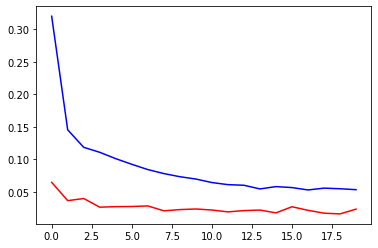

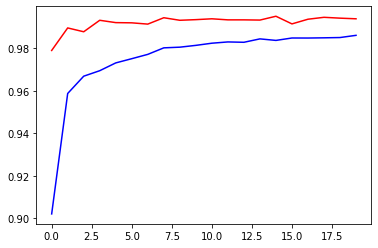

In [0]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

**Check the comfusion matrix on test data.**

In [0]:
y_hat = model.predict(x_test)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 980    0    0    0    0    0    0    0    0    0]
 [   0 1132    0    0    0    0    0    3    0    0]
 [   1    0 1022    1    0    0    0    7    1    0]
 [   0    0    0 1008    0    0    0    1    1    0]
 [   0    0    0    0  966    0    0    1    0   15]
 [   0    0    0    5    0  884    1    0    1    1]
 [   3    3    0    1    2    0  943    0    6    0]
 [   0    2    0    0    0    0    0 1026    0    0]
 [   0    0    1    2    0    0    0    0  970    1]
 [   0    0    0    0    0    0    0    0    1 1008]]
